## InceptionV3 Model

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras.callbacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.callbacks (from versions: none)
ERROR: No matching distribution found for keras.callbacks


In [ ]:
train_dir = "/content/drive/MyDrive/Leukemia - Copy/train/"
valid_dir = "/content/drive/MyDrive/Leukemia - Copy/test/"

img_width, img_height = 299, 299

In [ ]:
conv_base = InceptionV3(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))

# Show architecture
conv_base.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count,4))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, 60)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(valid_dir, 35)
# test_features, test_labels = extract_features(test_dir, test_size)

Found 60 images belonging to 4 classes.
1/1 [==============================] - 7s 7s/step
Found 35 images belonging to 4 classes.
1/1 [==============================] - 1s 658ms/step


In [ ]:
train_labels

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],


In [ ]:
epochs = 20

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=(8,8,2048)))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 8,196
Trainable params: 8,196
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

# Compile model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

# Train model

from time import perf_counter, sleep

start = perf_counter()
# Some Code
history = model.fit(train_features, train_labels,
                    epochs=epochs,
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    validation_data=(validation_features, validation_labels))
end = perf_counter()

print(f"Time taken to execute code : {end-start}")


Epoch 1/20
1/2 [==============>...............] - ETA: 0s - loss: 1.5150 - acc: 0.2188
Epoch 1: val_loss improved from inf to 0.98902, saving model to model-001-0.433333-0.714286.h5
2/2 [==============================] - 1s 250ms/step - loss: 1.3301 - acc: 0.4333 - val_loss: 0.9890 - val_acc: 0.7143
Epoch 2/20
1/2 [==============>...............] - ETA: 0s - loss: 1.0219 - acc: 0.7188
Epoch 2: val_loss improved from 0.98902 to 0.73256, saving model to model-002-0.816667-1.000000.h5
2/2 [==============================] - 0s 59ms/step - loss: 0.9415 - acc: 0.8167 - val_loss: 0.7326 - val_acc: 1.0000
Epoch 3/20
1/2 [==============>...............] - ETA: 0s - loss: 0.7302 - acc: 1.0000
Epoch 3: val_loss improved from 0.73256 to 0.53993, saving model to model-003-1.000000-1.000000.h5
2/2 [==============================] - 0s 58ms/step - loss: 0.6781 - acc: 1.0000 - val_loss: 0.5399 - val_acc: 1.0000
Epoch 4/20
1/2 [==============>...............] - ETA: 0s - loss: 0.5275 - acc: 1.0000
Epoc

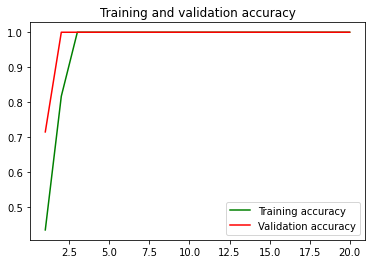

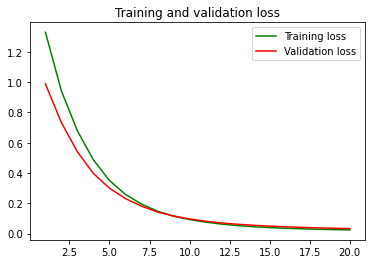

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras_preprocessing import image
def prediction(img_path):
    org_img = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(org_img)                           
    plt.axis('off')
    plt.show()


    # Extract features
    features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

    # Make prediction
    try:
        prediction = model.predict(features)
    except:
        prediction = model.predict(features.reshape(1, 8*8*2048))
        
    classes = ["ALL", "AML", "CLL", "CML"]
    print(str(classes[np.argmax(np.array(prediction[0]))]))

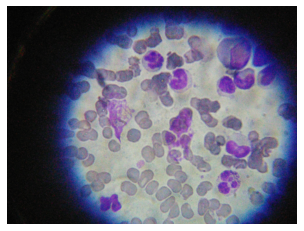

1/1 [==============================] - 0s 40ms/step
CML


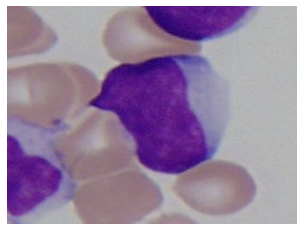

1/1 [==============================] - 0s 17ms/step
ALL


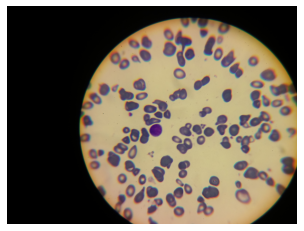

1/1 [==============================] - 0s 18ms/step
CLL


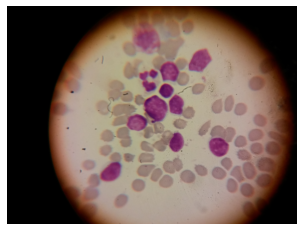

1/1 [==============================] - 0s 18ms/step
CLL


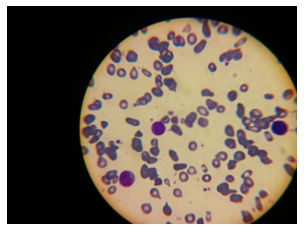

1/1 [==============================] - 0s 18ms/step
CLL


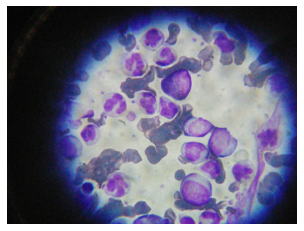

1/1 [==============================] - 0s 17ms/step
CML


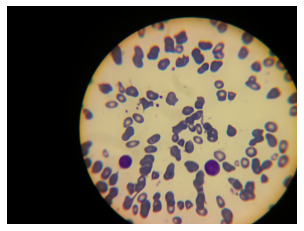

1/1 [==============================] - 0s 17ms/step
CLL


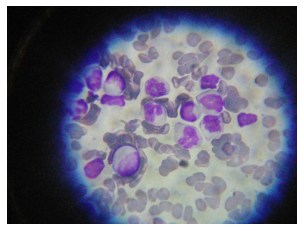

1/1 [==============================] - 0s 17ms/step
CML


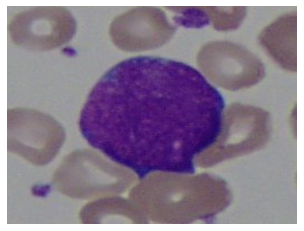

1/1 [==============================] - 0s 17ms/step
ALL


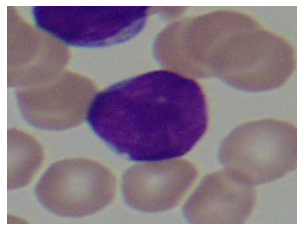

1/1 [==============================] - 0s 16ms/step
ALL


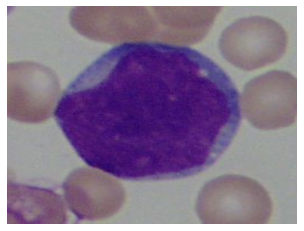

1/1 [==============================] - 0s 18ms/step
ALL


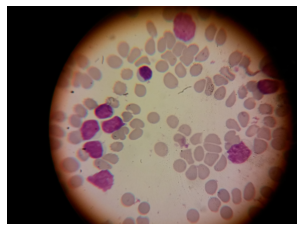

1/1 [==============================] - 0s 17ms/step
CLL


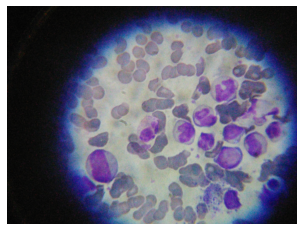

1/1 [==============================] - 0s 19ms/step
CML


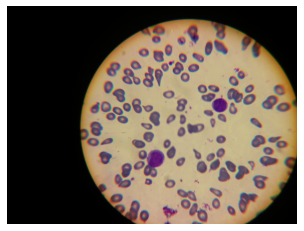

1/1 [==============================] - 0s 37ms/step
CLL


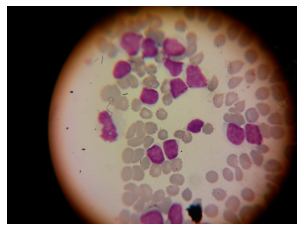

1/1 [==============================] - 0s 23ms/step
CLL


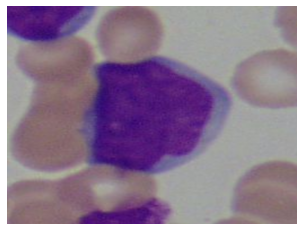

1/1 [==============================] - 0s 18ms/step
ALL


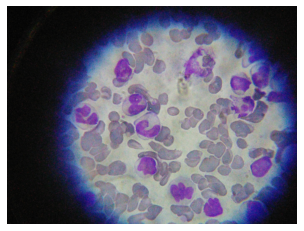

1/1 [==============================] - 0s 26ms/step
CML


In [ ]:
pred_dir = "/content/drive/MyDrive/Leukemia/prediction/"
import random
pred_files = random.sample(os.listdir(pred_dir),17)
for f in pred_files:
    prediction(pred_dir+f)

In [ ]:
training_accuracy_inception= history.history['acc'][-1]
print("Training Accuracy inception   :", training_accuracy_inception )
training_loss_inception= history.history['loss'][-1]
print("Training Loss inception:    ", training_loss_inception)

validation_accuracy_inception= history.history['val_acc'][-1]
print("Validation Accuracy inception :", validation_accuracy_inception)
validation_loss_inception= history.history['val_loss'][-1]
print("Validation Loss inception     :", validation_loss_inception)

Training Accuracy inception   : 1.0
Training Loss inception:     0.02403571456670761
Validation Accuracy inception : 1.0
Validation Loss inception     : 0.032760653644800186
